In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, gaussian_kde
import astropy.constants as cons

# Maths
For two masses m and M in binary with orbital velocity $v_{orb}$ and period P at a speration a,
$$
\frac{mv_{orb}^2}{a} = \frac{GMm}{a^2} \Rightarrow v_{orb}^2 = \frac{GM}{a} = \frac{G.(M_{\odot}\text{ in kg})}{(\text{AU in m})} \Big( \frac{M}{M_{\odot}} \Big) \Big( \frac{a}{AU} \Big)^{-1}
$$

Now
$$
a = \frac{v_{orb}P}{2\pi}
$$

Hence
$$
v_{orb}^2 = \frac{GM}{a} = \frac{GM2\pi}{v_{orb}P} \Rightarrow v_{orb} = (2\pi G)^{1/3} \Big(\frac{M}{P} \Big)^{1/3}
$$

Here, we find the distribution of $v_{orb}$ with the distribution of $M$ and $P$.

The kick velocity is $v_{kick}$, and we compare it with $v_{orb}$.

In [37]:
def vorb_in_kmps(M, a): # Change to (M, P) if we are given IMF and initial period distribution
    AU_to_m = 1.496e+11
    Solar_M_in_kg = 1.989e+30
    return ((cons.G.value*Solar_M_in_kg/AU_to_m) * M/a)**0.5/1000

class PowerLawPDF(object): # Taken from https://github.com/farr/BumpCosmology/blob/main/src/scripts/mock_injections.py
    def __init__(self, alpha, a, b):
        assert alpha > 1

        self.alpha = alpha
        self.a = a
        self.b = b

        self.norm = (self.a - (self.a/self.b)**self.alpha*self.b)/(self.a*(self.alpha-1))

    def __call__(self, x):
        return (self.a/x)**self.alpha/self.a/self.norm
    
    def icdf(self, c):
        return ((self.a**self.alpha*self.b*c + self.a*self.b**self.alpha*(1-c))/(self.a*self.b)**self.alpha)**(1/(1-self.alpha))

rng = np.random.default_rng(333165393797366967556667466879860422123)
ndraw = 10000

powerlawindex = 2.35
mmin = 1 # In solar masses
mmax = 100
imfpdf = PowerLawPDF(powerlawindex, mmin, mmax) # Change it to something else for different imf.
M = imfpdf.icdf(rng.uniform(low=0, high=1, size=ndraw)) # Solar mass

loga = rng.uniform(low=np.log(0.01), high=np.log(1000), size=ndraw) # AU
a = np.exp(loga)

vorb = vorb_in_kmps(M, a) # In km/s

In [38]:
sigmakick = 200 # In km/s
vkick = maxwell(loc=0., scale=sigmakick).rvs(size=ndraw) # In km/s

Text(0, 0.5, 'Population Density')

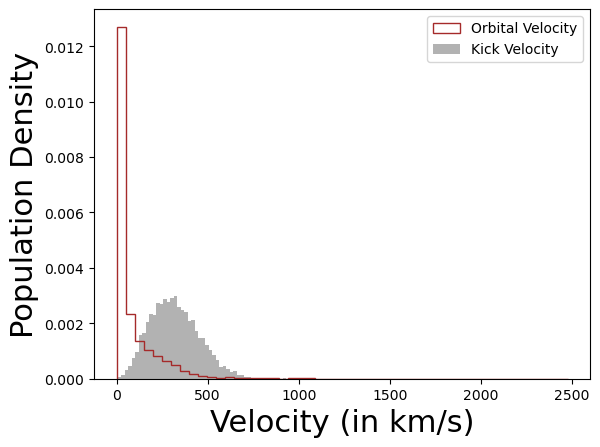

In [39]:
_ = plt.hist(vorb, bins=50, histtype='step', density=True, color='brown', label='Orbital Velocity')
_ = plt.hist(vkick, bins=50, density=True, color='grey', alpha=0.6, label='Kick Velocity')
plt.legend()
plt.xlabel(r'Velocity (in km/s)', fontsize=22)
plt.ylabel(r'Population Density', fontsize=22)

To check $v_{orb}<v_{kick}$, we define:
$$
x = v_{kick} - v_{orb}
$$
and check at what confidence $x>0$.

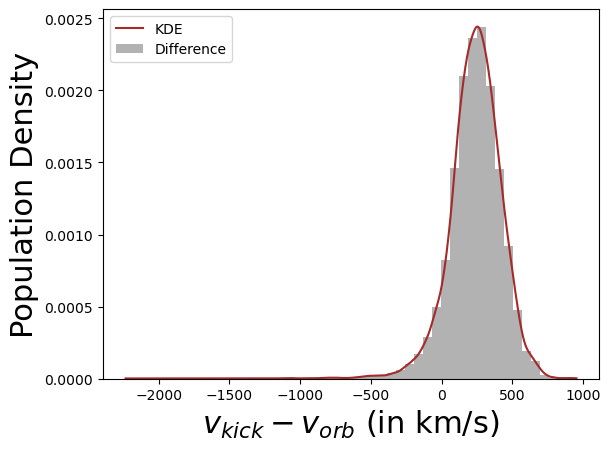

In [40]:
x = vkick - vorb
kernel = gaussian_kde(x)

plt.plot(np.sort(x), kernel.pdf(np.sort(x)), color='brown', label='KDE')
_ = plt.hist(x, bins=50, density=True, color='grey', alpha=0.6, label='Difference')
plt.legend()
plt.xlabel(r'$v_{kick}-v_{orb}$ (in km/s)', fontsize=22)
plt.ylabel(r'Population Density', fontsize=22);

In [41]:
prob = kernel.integrate_box_1d(low=0, high=1000)
print('Probability of vkick>vorb:', prob*100, '%')

Probability of vkick>vorb: 91.65401533634551 %


# Hence $v_{kick}>v_{orb}$ 91.6% of the times.